# ResNet-18 U-Net for mNDWS Next-Day Wildfire Spread
This notebook implements a reproducible, higher-capacity segmentation baseline aligned with the Milestone-2 feedback: a compact U-Net that leverages a ResNet-18 encoder, focal(\u03b3=2)+Dice loss, stratified loaders from `mNDWS_DataPipeline`, and metric logging compatible with the logistic-regression and EMA notebooks.

**Highlights**:
- Uses the shared NPZ tiles + channel stats so it plugs into the same pipeline as earlier deliverables.
- Tracks epoch timing, tile throughput, GPU memory, AP/F1/threshold, and saves the best checkpoint under `~/wildfire_artifacts/resnet18_unet`.
- Includes hooks for ablations (wind toggles, loss variants) and visual diagnostics for qualitative review.
- Designed for a single 12-core / 32 GB RAM workstation with a 4-core GPU (e.g., RTX 4060/4070); default batch sizes keep VRAM < 10 GB.

In [16]:
# =============================================================
## 0) Environment setup, deterministic seeds, device selection
## =============================================================
import os, math, random, time, json, gc, pathlib, shutil
from contextlib import nullcontext
from dataclasses import dataclass, asdict
from typing import Dict, List, Tuple
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.metrics import average_precision_score, precision_recall_curve

os.environ.setdefault("MNDWS_PIPELINE_SILENT", "1")
import mNDWS_DataPipeline as mndws_dp

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(42)

if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

workspace_root = pathlib.Path.cwd()
ART_ROOT = pathlib.Path(os.environ.get("ARTIFACTS_DIR", os.path.expanduser("~/wildfire_artifacts"))) / "resnet18_unet"
ART_ROOT.mkdir(parents=True, exist_ok=True)
print(f"Artifacts -> {ART_ROOT}")

Using device: cuda
Artifacts -> /home/jbm2rt/wildfire_artifacts/resnet18_unet


In [17]:
# =============================================================
# 1) Data pipeline hookup + loaders + channel stats
# =============================================================
NPZ_ROOT = mndws_dp.NPZ_ROOT
paths = mndws_dp.WildfirePaths(NPZ_ROOT)
CHANNELS = list(mndws_dp.USE_CHANNELS)  # tweak here for ablations
print(f"Using {len(CHANNELS)} channels: {CHANNELS}")

train_ds = mndws_dp.WildfireDataset(paths, split="train", max_samples=None, channels=CHANNELS)
val_ds   = mndws_dp.WildfireDataset(paths, split="eval",  max_samples=None, channels=CHANNELS)
test_ds  = mndws_dp.WildfireDataset(paths, split="test",  max_samples=None, channels=CHANNELS)

BATCH_SIZE = 8
train_loader = mndws_dp.make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, upweight_positive=True)
val_loader   = mndws_dp.make_loader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = mndws_dp.make_loader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

meanC, stdC = mndws_dp.compute_channel_stats(train_ds, n_max_samples=4000, batch_size=32)
meanC, stdC = meanC.to(device), stdC.to(device)

print("Channel stats computed ->", meanC.shape, stdC.shape)

Using 21 channels: ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water', 'wind_75', 'gust_med']
Channel stats computed -> torch.Size([21]) torch.Size([21])


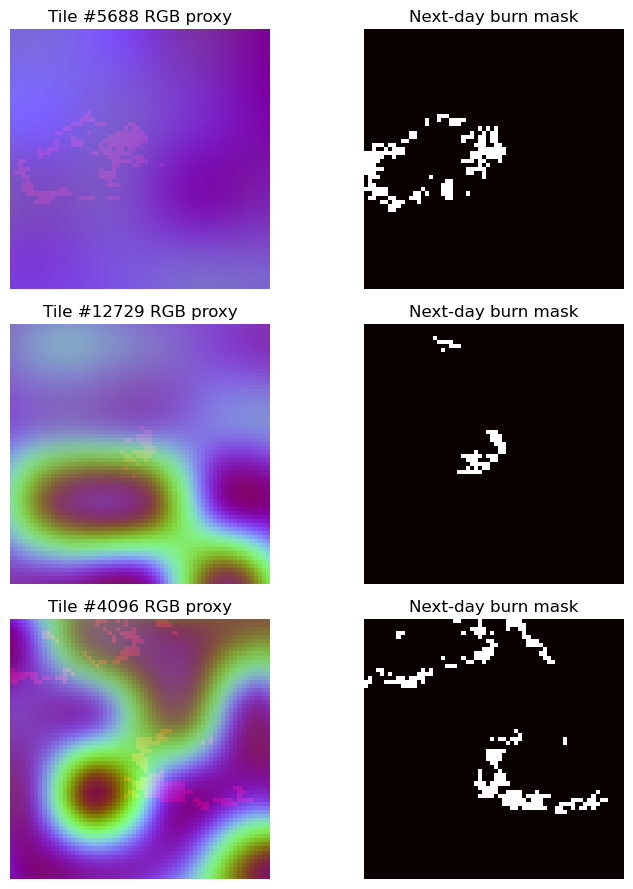

In [18]:
# =============================================================
# 2) Visualization helpers (dataset verification requirement)
# =============================================================
def to_numpy_tile(sample):
    x = sample["X_raw"].numpy()
    y = sample["y"].numpy()
    return x, y

def show_samples(ds, n=5):
    idxs = np.random.choice(len(ds), size=min(n, len(ds)), replace=False)
    fig, axes = plt.subplots(len(idxs), 2, figsize=(8, 3*len(idxs)))
    if len(idxs) == 1:
        axes = np.expand_dims(axes, axis=0)
    for row, idx in enumerate(idxs):
        sample = ds[idx]
        x, y = to_numpy_tile(sample)
        burn = y[0]
        viz = x[:3] if x.shape[0] >= 3 else np.repeat(x[:1], 3, axis=0)
        viz = (viz - viz.min()) / (viz.max() - viz.min() + 1e-6)
        axes[row,0].imshow(np.moveaxis(viz, 0, -1))
        axes[row,0].set_title(f"Tile #{idx} RGB proxy")
        axes[row,0].axis("off")
        axes[row,1].imshow(burn, cmap="hot")
        axes[row,1].set_title("Next-day burn mask")
        axes[row,1].axis("off")
    plt.tight_layout()

_ = show_samples(train_ds, n=3)

In [19]:
# =============================================================
# 3) Model definition – ResNet-18 encoder + lightweight decoder
# =============================================================
from torchvision.models import ResNet18_Weights

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=0.0):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout) if dropout > 0 else nn.Identity(),
        )
    def forward(self, x):
        return self.block(x)

class UpBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch, dropout=0.0):
        super().__init__()
        self.conv = ConvBlock(in_ch + skip_ch, out_ch, dropout=dropout)
    def forward(self, x, skip):
        x = F.interpolate(x, size=skip.shape[-2:], mode="bilinear", align_corners=False)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

class ResNet18UNet(nn.Module):
    def __init__(self, in_ch=15, base_ch=64, pretrained=True):
        super().__init__()
        weights = ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
        resnet = models.resnet18(weights=weights)
        if in_ch != 3:
            new_conv = nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)
            if weights is not None:
                with torch.no_grad():
                    new_conv.weight[:, :3] = resnet.conv1.weight
                    if in_ch > 3:
                        for c in range(3, in_ch):
                            new_conv.weight[:, c:c+1] = resnet.conv1.weight[:, (c % 3):(c % 3)+1]
            resnet.conv1 = new_conv
        self.stem = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)
        self.maxpool = resnet.maxpool
        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4
        
        self.center = ConvBlock(512, 512, dropout=0.1)
        self.up3 = UpBlock(512, 256, 256)
        self.up2 = UpBlock(256, 128, 128)
        self.up1 = UpBlock(128, 64, 96)
        self.up0 = UpBlock(96, 64, base_ch)
        self.head = nn.Sequential(
            nn.Conv2d(base_ch, base_ch // 2, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_ch // 2, 1, kernel_size=1)
        )
    def forward(self, x):
        s0 = self.stem(x)                # 64
        s1 = self.maxpool(s0)
        e1 = self.encoder1(s1)          # 64
        e2 = self.encoder2(e1)          # 128
        e3 = self.encoder3(e2)          # 256
        e4 = self.encoder4(e3)          # 512
        bottleneck = self.center(e4)
        d3 = self.up3(bottleneck, e3)
        d2 = self.up2(d3, e2)
        d1 = self.up1(d2, e1)
        d0 = self.up0(d1, s0)
        out = F.interpolate(d0, scale_factor=2, mode="bilinear", align_corners=False)
        return self.head(out)

model = ResNet18UNet(in_ch=len(CHANNELS), base_ch=96, pretrained=True).to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6:.2f} M")

Model parameters: 19.42 M


In [20]:
# =============================================================
## 4) Losses, metrics, and normalization helpers
## =============================================================
def normalize_batch(x):
    return (x - meanC.view(1, -1, 1, 1)) / (stdC.view(1, -1, 1, 1) + 1e-6)

class FocalDiceLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, smooth=1e-6, dice_weight=0.5):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smooth = smooth
        self.dice_weight = dice_weight
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        bce = F.binary_cross_entropy_with_logits(logits, targets, reduction="none")
        pt = torch.exp(-bce)
        focal = ((1 - pt) ** self.gamma) * bce
        focal = self.alpha * targets * focal + (1 - self.alpha) * (1 - targets) * focal
        focal = focal.mean()
        inter = torch.sum(probs * targets)
        denom = torch.sum(probs) + torch.sum(targets)
        dice = 1 - (2 * inter + self.smooth) / (denom + self.smooth)
        return (1 - self.dice_weight) * focal + self.dice_weight * dice

criterion = FocalDiceLoss(alpha=0.3, gamma=2.0, dice_weight=0.4)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40, eta_min=1e-5)

class _NoOpGradScaler:
    def scale(self, loss):
        return loss
    def step(self, optimizer):
        optimizer.step()
    def update(self):
        pass

if device.type == "cuda":
    scaler = torch.amp.GradScaler("cuda", enabled=True)
else:
    scaler = _NoOpGradScaler()

def amp_autocast():
    if device.type == "cuda":
        return torch.autocast("cuda", dtype=torch.float16)
    if device.type == "mps":
        return torch.autocast("mps", dtype=torch.bfloat16)
    return nullcontext()

def pr_metrics(all_logits, all_targets):
    probs = torch.sigmoid(torch.cat(all_logits, dim=0)).flatten().cpu().numpy()
    t = torch.cat(all_targets, dim=0).flatten().cpu().numpy()
    if t.sum() == 0:
        return {"AP": 0.0, "best_F1": 0.0, "best_thr": 0.5, "best_prec": 0.0, "best_rec": 0.0}
    ap = average_precision_score(t, probs)
    prec, rec, thr = precision_recall_curve(t, probs)
    f1 = (2 * prec * rec) / (prec + rec + 1e-8)
    idx = np.nanargmax(f1)
    best_thr = thr[min(idx, len(thr)-1)] if len(thr) else 0.5
    return {"AP": float(ap), "best_F1": float(np.nanmax(f1)), "best_thr": float(best_thr),
            "best_prec": float(prec[idx]), "best_rec": float(rec[idx])}

def random_augment(x):
    if torch.rand(1) < 0.5:
        x = torch.flip(x, dims=[-1])
    if torch.rand(1) < 0.5:
        x = torch.flip(x, dims=[-2])
    if torch.rand(1) < 0.1:
        x = x + 0.01 * torch.randn_like(x)
    return x

In [21]:
# =============================================================
## 5) Training / validation loops with instrumentation
## =============================================================
def train_one_epoch(epoch):
    model.train()
    losses = []
    tiles = 0
    for batch in tqdm(train_loader, desc=f"train[{epoch:02d}]", leave=False):
        x = batch["X_raw"].to(device, non_blocking=True)
        y = batch["y"].to(device, non_blocking=True)
        x = random_augment(x)
        x = normalize_batch(x)
        optimizer.zero_grad(set_to_none=True)
        with amp_autocast():
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        losses.append(loss.item())
        tiles += x.size(0)
    return float(np.mean(losses)), tiles

@torch.no_grad()
def evaluate(loader):
    model.eval()
    losses = []
    logits_all, targets_all = [], []
    for batch in tqdm(loader, desc="eval", leave=False):
        x = normalize_batch(batch["X_raw"].to(device, non_blocking=True))
        y = batch["y"].to(device, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y).item()
        losses.append(loss)
        logits_all.append(logits.detach())
        targets_all.append(y.detach())
    metrics = pr_metrics(logits_all, targets_all)
    metrics["loss"] = float(np.mean(losses)) if losses else float("nan")
    return metrics

def save_checkpoint(state, name):
    path = ART_ROOT / name
    torch.save(state, path)
    return path

In [22]:
# =============================================================
# 6) Training driver (configurable epochs, patience, logging)
# =============================================================
MAX_EPOCHS = 40
PATIENCE = 6
history = {"train_loss": [], "val_AP": [], "val_F1": [], "val_thr": [], "lr": [], "epoch_time": []}
best_ap = -1
best_state = None
best_epoch = -1
tiles_seen = []
if device.type == "cuda":
    torch.cuda.reset_peak_memory_stats(device)
for epoch in range(MAX_EPOCHS):
    torch.cuda.empty_cache() if device.type == "cuda" else None
    torch.mps.empty_cache() if hasattr(torch, "mps") and device.type == "mps" else None
    start = time.perf_counter()
    tr_loss, tiles = train_one_epoch(epoch)
    metrics = evaluate(val_loader)
    scheduler.step()
    duration = time.perf_counter() - start
    throughput = tiles / duration if duration > 0 else float('nan')
    history["train_loss"].append(tr_loss)
    history["val_AP"].append(metrics["AP"])
    history["val_F1"].append(metrics["best_F1"])
    history["val_thr"].append(metrics["best_thr"])
    history["lr"].append(optimizer.param_groups[0]["lr"])
    history["epoch_time"].append({"sec": duration, "throughput_tiles_per_s": throughput})
    tiles_seen.append(tiles)
    print(f"Epoch {epoch:02d} | train {tr_loss:.4f} | val AP {metrics['AP']:.4f} | val F1* {metrics['best_F1']:.4f} | thr {metrics['best_thr']:.3f} | {duration:.1f}s")
    if metrics["AP"] > best_ap:
        best_ap = metrics["AP"]
        best_state = {"model": model.state_dict(), "optimizer": optimizer.state_dict(), "epoch": epoch, "metrics": metrics}
        best_epoch = epoch
        save_checkpoint(best_state, "best.pt")
    if epoch - best_epoch >= PATIENCE:
        print(f"Early stopping at epoch {epoch} (best @ {best_epoch})")
        break

if best_state is not None:
    model.load_state_dict(best_state["model"])
training_summary = {
    "best_epoch": best_epoch,
    "best_AP": best_ap,
    "history": history,
    "tiles_total": int(np.sum(tiles_seen))
}
if device.type == "cuda":
    training_summary["peak_gpu_gb"] = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))
json.dump(training_summary, open(ART_ROOT / "training_summary.json", "w"), indent=2)
training_summary

train[00]:   0%|          | 0/1759 [00:00<?, ?it/s]

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/apps/software/standard/core/jupyterlab/4.4.6-py3.12/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/apps/software/standard/core/jupyterlab/4.4.6-py3.12/lib/python3.12/site-packages/tqdm/_monitor.py", line 84, in run
    instance.refresh(nolock=True)
  File "/apps/software/standard/core/jupyterlab/4.4.6-py3.12/lib/python3.12/site-packages/tqdm/std.py", line 1347, in refresh
    self.display()
  File "/apps/software/standard/core/jupyterlab/4.4.6-py3.12/lib/python3.12/site-packages/tqdm/notebook.py", line 171, in display
    rtext.value = right
    ^^^^^^^^^^^
  File "/apps/software/standard/core/jupyterlab/4.4.6-py3.12/lib/python3.12/site-packages/traitlets/traitlets.py", line 716, in __set__
    self.set(obj, value)
  File "/apps/software/standard/core/jupyterlab/4.4.6-py3.12/lib/python3.12/site-packages/traitlets/traitlets.py", line 706, in set
    obj._notify_trait(self.name

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 00 | train 0.3525 | val AP 0.2697 | val F1* 0.3818 | thr 0.222 | 97.7s


train[01]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 01 | train 0.3410 | val AP 0.2794 | val F1* 0.3647 | thr 0.277 | 42.4s


train[02]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 02 | train 0.3353 | val AP 0.2972 | val F1* 0.3853 | thr 0.233 | 43.1s


train[03]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 03 | train 0.3317 | val AP 0.2399 | val F1* 0.3187 | thr 0.173 | 43.2s


train[04]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 04 | train 0.3227 | val AP 0.2529 | val F1* 0.3195 | thr 0.171 | 42.7s


train[05]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 05 | train 0.3156 | val AP 0.2903 | val F1* 0.3706 | thr 0.123 | 42.6s


train[06]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 06 | train 0.3080 | val AP 0.2722 | val F1* 0.3444 | thr 0.100 | 42.3s


train[07]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 07 | train 0.3021 | val AP 0.2276 | val F1* 0.3005 | thr 0.287 | 41.9s


train[08]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 08 | train 0.2948 | val AP 0.2532 | val F1* 0.3252 | thr 0.058 | 42.5s
Early stopping at epoch 8 (best @ 2)


{'best_epoch': 2,
 'best_AP': 0.2971783134680491,
 'history': {'train_loss': [0.3525215181066205,
   0.3409504653497336,
   0.33526335631228765,
   0.33170671506894456,
   0.32272505615332236,
   0.31561108811156463,
   0.3080223295805873,
   0.3021312036285216,
   0.2947502289816627],
  'val_AP': [0.26973393740584706,
   0.27942441203871704,
   0.2971783134680491,
   0.23992394291275693,
   0.25292533437096815,
   0.29027735909790825,
   0.2721813195500001,
   0.22761502148178162,
   0.25321126963525614],
  'val_F1': [0.3818080492941568,
   0.36467768279213747,
   0.38526376688761604,
   0.31867455444867004,
   0.31949901704929123,
   0.3706353447704441,
   0.34439871184531606,
   0.3004695201917835,
   0.32520970719477305],
  'val_thr': [0.22209817171096802,
   0.27672457695007324,
   0.23251457512378693,
   0.17344720661640167,
   0.17097459733486176,
   0.12345270067453384,
   0.10001681745052338,
   0.2872174084186554,
   0.058446209877729416],
  'lr': [0.00029955301339130357,
   

test:   0%|          | 0/377 [00:00<?, ?it/s]

TEST metrics: {'AP': 0.24594577372305937, 'best_F1': 0.3173408480539053, 'best_thr': 0.05218493938446045, 'best_prec': 0.23802663302345226, 'best_rec': 0.4759273263659709}
Confusion counts: {'TP': 178102.0, 'FP': 570142.0, 'FN': 196119.0}


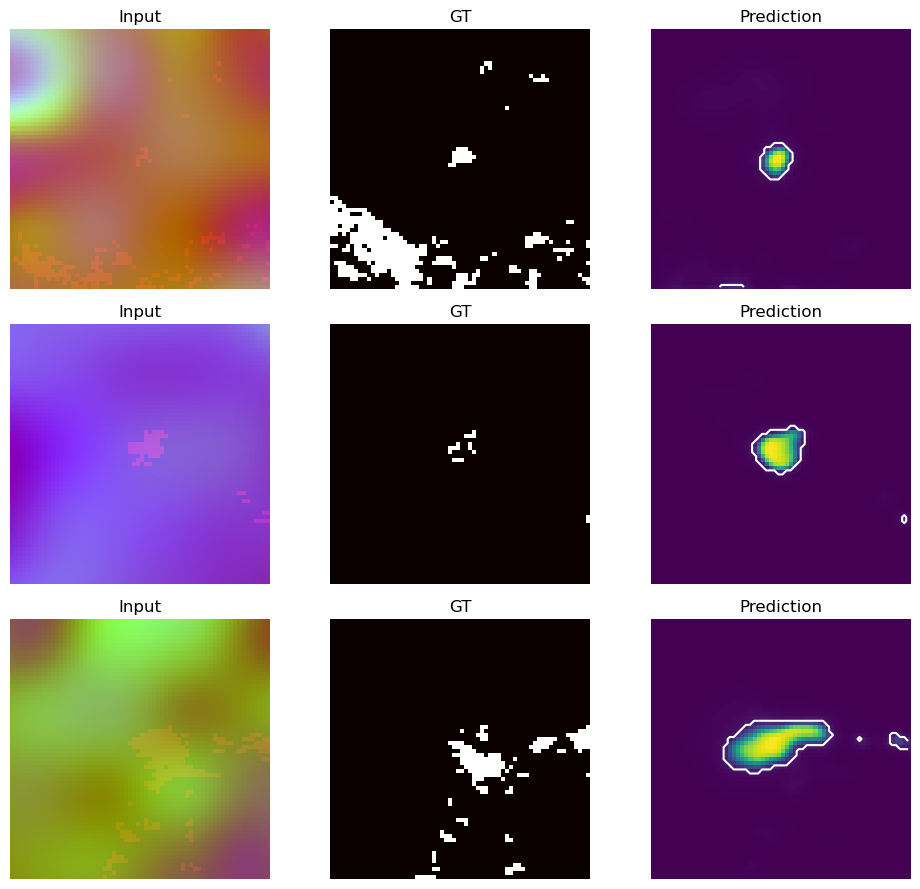

In [23]:
# =============================================================
# 7) Test-set evaluation + qualitative checks
# =============================================================
@torch.no_grad()
def run_test(loader, threshold=None):
    model.eval()
    logits_all, targets_all = [], []
    for batch in tqdm(loader, desc="test", leave=False):
        x = normalize_batch(batch["X_raw"].to(device, non_blocking=True))
        y = batch["y"].to(device, non_blocking=True)
        logits = model(x)
        logits_all.append(logits)
        targets_all.append(y)
    metrics = pr_metrics(logits_all, targets_all)
    thr = threshold if threshold is not None else metrics["best_thr"]
    preds = torch.sigmoid(torch.cat(logits_all, dim=0))
    binary = (preds >= thr).float()
    confusion = {
        "TP": float((binary * torch.cat(targets_all, dim=0)).sum().cpu()),
        "FP": float((binary * (1 - torch.cat(targets_all, dim=0))).sum().cpu()),
        "FN": float(((1 - binary) * torch.cat(targets_all, dim=0)).sum().cpu())
    }
    return metrics, confusion

test_metrics, confusion = run_test(test_loader)
print("TEST metrics:", test_metrics)
print("Confusion counts:", confusion)

def visualize_predictions(loader, n=4, threshold=None):
    loader_iter = iter(loader)
    thr = threshold if threshold is not None else test_metrics["best_thr"]
    fig, axes = plt.subplots(n, 3, figsize=(10, 3*n))
    for i in range(n):
        batch = next(loader_iter)
        x = normalize_batch(batch["X_raw"].to(device))
        y = batch["y"].to(device)
        with torch.no_grad():
            logits = model(x)
            prob = torch.sigmoid(logits)
        img = batch["X_raw"][:, :3].cpu().numpy()[0]
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)
        axes[i,0].imshow(np.moveaxis(img, 0, -1))
        axes[i,0].set_title("Input")
        axes[i,0].axis("off")
        axes[i,1].imshow(y[0,0].cpu(), cmap="hot")
        axes[i,1].set_title("GT")
        axes[i,1].axis("off")
        axes[i,2].imshow(prob[0,0].cpu(), cmap="viridis")
        axes[i,2].contour((prob[0,0].cpu() >= thr).float(), levels=[0.5], colors="white")
        axes[i,2].set_title("Prediction")
        axes[i,2].axis("off")
    plt.tight_layout()

visualize_predictions(test_loader, n=3)

## Next steps and tuning notes
- **Wind ablation:** toggle wind channels by editing `CHANNELS` and re-running to quantify the expected ~10% AP drop.
- **Loss sweep:** change `FocalDiceLoss` weights to compare focal+Dice vs weighted BCE; log results into `training_summary.json`.
- **Hyper-band:** adjust `BATCH_SIZE`, `MAX_EPOCHS`, and `CosineAnnealingLR` length; instrumentation already captures throughput and GPU memory so you can report scaling on the 12-core workstation.
- **Logging:** drop-in integrations with Weights & Biases / MLflow can be added where the `history` dict is populated if cloud tracking becomes mandatory.